# Model annealing
Infer a cosmological model via Continuous Tempering Langevin. 

In [23]:
!hostname
!python -c "import jax; print(jax.default_backend(), jax.devices())"
# !nvidia-smi
# numpyro.set_platform("gpu")

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.33' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import random, jit, vmap, grad

import numpyro
from numpyro.handlers import seed, condition, trace
from functools import partial

%matplotlib inline
%load_ext autoreload 
%autoreload 2

import mlflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("Continuous Tempering Langevin");
# mlflow.end_run()
# mlflow.start_run(run_name="Zee")
# mlflow.log_params({"ho":2, "ha":np.array([2,3])})
# mlflow.log_metrics({"ho":2, "ha":3}, step=1)

feynmangpu04.cluster.local
gpu [cuda(id=0)]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import and simulate fiducial

In [27]:
def get_simulator(model, cond_params={}):
    """
    Return a simulator that samples from a model, conditioned on some parameters.
    """
    def sample_model(model, cond_params, rng_seed=0, model_kwargs={}):
        cond_model = condition(model, cond_params) # NOTE: Only condition on random sites
        cond_trace = trace(seed(cond_model, rng_seed=rng_seed)).get_trace(**model_kwargs)
        params = {name: cond_trace[name]['value'] for name in cond_trace.keys()}
        return params

    vsample_model = vmap(partial(sample_model, model, cond_params), in_axes=(0,None))

    @partial(jit, static_argnames=('batch_size'))
    def simulator(batch_size=1, rng_key=random.PRNGKey(0), model_kwargs={}): # TODO add doc
        keys = random.split(rng_key, batch_size)
        return vsample_model(keys, model_kwargs)

    return simulator


from numpyro.infer.util import log_density
def get_logp_fn(model, cond_params={}):
    """
    Return the log probabilty function of a model, conditioned on some parameters.
    """
    def logp_model(model, cond_params, params, model_kwargs={}):
        cond_model = condition(model, cond_params)
        logp = log_density(model=cond_model, 
                    model_args=(), 
                    model_kwargs=model_kwargs, 
                    params=params)[0]
        return logp
    
    vlogp_model = vmap(partial(logp_model, model, cond_params), in_axes=(0,None))

    @jit
    def logp_fn(params, model_kwargs={}): # TODO: add doc
        return vlogp_model(params, model_kwargs)
    
    return logp_fn

In [30]:
from montecosmo.models import pmrsd_model, model_config
model_config['scale_factor_lpt'] = 0.5
model_config['scale_factor_obs'] = 0.5
model_config['mesh_size'] = 16*np.array([1,1,1])
print(f"{model_config=}")

model = partial(pmrsd_model, **model_config)

# Cosmological parameters
cosmo_names = ['Omega_c', 'sigma8']
cosmo_labels = [r'\Omega_c', r'\sigma_8']
cond_params = {var_name+"_base": 0. for var_name in cosmo_names}

fiducial_simulator = get_simulator(model, cond_params)
fiducial_params = fiducial_simulator(batch_size=5)
fiducial_cosmo_params = {name: fiducial_params[name] for name in cosmo_names}

# Check cosmology
from jax_cosmo import Planck15
fiducial_cosmology = Planck15(**fiducial_cosmo_params)
print(f"Fiducial {fiducial_cosmology}")

# Condition model
obs_names = ['obs_mesh'] # NOTE: Only condition on random sites
obs_params = {name: fiducial_params[name][0] for name in obs_names}
observed_model = condition(model, obs_params)  

# Parameters to initialize samplers on
init_names = ['Omega_c_base', 'sigma8_base', 'init_mesh_base'] # NOTE: Only init on random sites
init_params = {name: fiducial_params[name] for name in init_names}

model_config={'mesh_size': array([16, 16, 16]), 'box_size': array([640, 640, 640]), 'scale_factor_lpt': 0.5, 'scale_factor_obs': 0.5, 'galaxy_density': 0.001, 'trace_reparam': True, 'trace_deterministic': False}
Fiducial Cosmological parameters: 
    h:        0.6774 
    Omega_b:  0.0486 
    Omega_c:  [0.25 0.25 0.25 0.25 0.25] 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9667 
    sigma8:   [0.831 0.831 0.831 0.831 0.831]


In [31]:
from numpyro.infer.util import log_density

params = {name: fiducial_params[name][0] for name in fiducial_params.keys()}
logp_unvec = log_density(model=observed_model, 
                            model_args=(), 
                            model_kwargs={}, 
                            params=params)[0]

logp_fn = get_logp_fn(observed_model)
logp_vec = logp_fn(fiducial_params)

logp_unvec, logp_vec

(Array(-20167.176, dtype=float32),
 Array([-20167.176, -20203.193, -20166.049, -20127.39 , -20186.682],      dtype=float32))

In [18]:
def get_simulator(model, cond_params={}):
    """
    Return a simulator that samples from a model conditioned on some parameters.
    """
    def sample_model(model, cond_params, rng_seed=0, model_kwargs={}):
        if len(model_kwargs)==0:
            model_kwargs = {}
        cond_model = condition(model, cond_params) # NOTE: Only condition on random sites
        cond_trace = trace(seed(cond_model, rng_seed=rng_seed)).get_trace(**model_kwargs)
        params = {name: cond_trace[name]['value'] for name in cond_trace.keys()}
        return params

    vsample_model = vmap(partial(sample_model, model, cond_params), in_axes=(None,0))
    vvsample_model = vmap(vsample_model, in_axes=(0,None))

    @partial(jit, static_argnames=('batch_size'))
    def simulator(batch_size=1, rng_key=random.PRNGKey(0), model_kwargs={}):
        """
        Sample batches from model. If they are both strict greater than one, 
        batch size would be left-most dimension, and model arguments size the second left-most.
        """
        squeeze_axis = []
        if batch_size==1:
            squeeze_axis.append(0)
        if len(model_kwargs)==0:
            model_kwargs = jnp.array([[]]) # for vmap, because jnp.array([{}]) is not valid
            squeeze_axis.append(1)
        keys = random.split(rng_key, batch_size)
        params = vvsample_model(keys, model_kwargs)
        return {name: params[name].squeeze(axis=squeeze_axis) for name in params.keys()}

    return simulator


from numpyro.infer.util import log_density
def get_logp_fn(model, cond_params={}):

    def logp_model(model, cond_params, params, model_kwargs={}):
        if len(model_kwargs)==0:
            model_kwargs = {}
        cond_model = condition(model, cond_params)
        logp = log_density(model=cond_model, 
                    model_args=(), 
                    model_kwargs=model_kwargs, 
                    params=params)[0]
        return logp
    
    vlogp_model = vmap(partial(logp_model, model, cond_params), in_axes=(None,0))
    vvlogp_model = vmap(vlogp_model, in_axes=(0,None))

    @jit
    def logp_fn(params, model_kwargs={}):
        """
        Sample batches from model.
        If strictly greater than one, batch size would be left-most dimension, and model arguments length the second left-most.
        """
        params = {name: jnp.expand_dims(params[name],0) for name in params.keys()}
        squeeze_axis = [0]
        if len(model_kwargs)==0:
            model_kwargs = jnp.array([[]]) # for vmap, because jnp.array([{}]) is not valid
            squeeze_axis.append(1)
        logp = vvlogp_model(params, model_kwargs)
        return logp
        # return logp.squeeze(squeeze_axis)
    
    return logp_fn

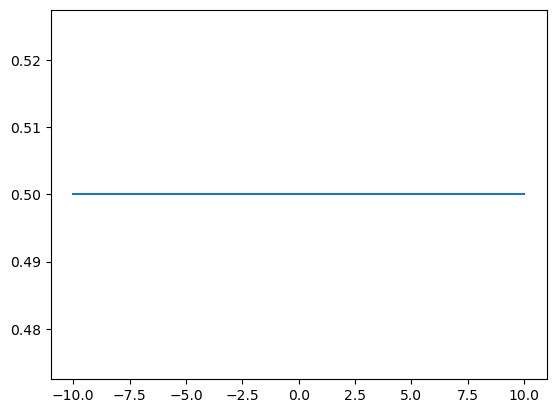

In [61]:
import numpyro.distributions as dist

def test():
    a = numpyro.sample('a', dist.Uniform(low=-1,high=1))
    # a = numpyro.sample('a', dist.Normal(loc=0, scale=1))
    return a

logp_fn = get_logp_fn(test)
x = jnp.linspace(-10,10,100)
plt.plot(x, jnp.exp(logp_fn({'a':x})))